# Détection des faux billets avec Python

## 1. Preliminary

Contexte : 

* Identification des contrefaçons des billets en euros
* Les billets d'euro ont des valeurs nominales de 5, 10, 20, 50, 100, 200 et 500 euros. 

# 1.2 Importation

## 1.2.1 Importation des librairies

In [1]:
#builtin
import os

In [2]:
#data
import pandas as pd
import numpy as np

In [3]:

#visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [4]:
#stat
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
#machine learning
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer

## 2.1 chargement des fichiers

In [6]:
input_folder = "../data/source/"
# Read CSV train data file into DataFrame
train_df= pd.read_csv(os.path.join(input_folder, "billets.csv"), dtype=float, sep=';')
# Read CSV test data file into DataFrame
test_df = pd.read_csv(os.path.join(input_folder, "billets_production.csv"), sep=',')

## 2. Prétraitement des données

## 2.2 Exploration

In [7]:
#Affichage des 5 premieres lignes
train_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [8]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(train_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 1500.


In [9]:
# preview test data
test_df

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


test DataFrame contient 5 lignes sans valeurs manquantes.

In [10]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(test_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 5.


Note: On ne voit pas la colonne 'is_genuine' (la target) dans le dataset test_df. Notre objectif est alors de prédire la target par differentes algorithmes de machine learning comme la regression logistique.

### Transform is_geniune into is_fake (revserse 0 and 1)

In [11]:
train_df['is_fake'] = 1 - train_df['is_genuine']
train_df['is_fake'].astype(int)
train_df.drop(columns=['is_genuine'], inplace=True)

In [12]:
#Affichage des 5 dernieres lignes
train_df.tail()

,diagonal,height_left,height_right,margin_low,margin_up,length,is_fake
1495,171.75,104.38,104.17,4.42,3.09,111.28,1.0
1496,172.19,104.63,104.44,5.27,3.37,110.97,1.0
1497,171.80,104.01,104.12,5.51,3.36,111.95,1.0
1498,172.06,104.28,104.06,5.17,3.46,112.25,1.0
1499,171.47,104.15,103.82,4.63,3.37,112.07,1.0


In [13]:
#Affichage de 5 lignes arbitrairement
train_df.sample(5)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_fake
868,172.23,103.87,104.05,3.90,3.09,113.38,0.0
841,172.36,103.92,103.08,3.69,3.10,112.88,0.0
1266,171.67,104.12,103.98,5.68,3.18,111.55,1.0
52,171.64,104.18,103.78,3.49,3.74,113.94,0.0
1067,171.37,104.08,104.16,5.55,3.55,111.56,1.0


In [14]:
#Dimensions du DataFrame
train_df.shape

(1500, 7)

In [15]:
#Information sur les colonnes
train_df.dtypes

diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
is_fake         float64
dtype: object

In [16]:
#Statistiques descriptives
train_df.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_fake
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68,0.33
std,0.31,0.30,0.33,0.66,0.23,0.87,0.47
min,171.04,103.14,102.82,2.98,2.27,109.49,0.00
25%,171.75,103.82,103.71,4.01,2.99,112.03,0.00
50%,171.96,104.04,103.92,4.31,3.14,112.96,0.00
75%,172.17,104.23,104.15,4.87,3.31,113.34,1.00
max,173.01,104.88,104.95,6.90,3.91,114.44,1.00


In [17]:
#Nombre des doublons dans le DataFrame
train_df.duplicated().sum()

0

In [18]:
#Nombre des doublons sans le target
train_df.drop(columns="is_fake").duplicated().sum()

0

In [19]:
#Information sur les valeurs unique dans chaque colonne
train_df.nunique()

diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
is_fake           2
dtype: int64

In [20]:
#Nombre des valeurs dans la target
train_df['is_fake'].value_counts()

is_fake
0.0    1000
1.0     500
Name: count, dtype: int64

In [21]:
#creation de la colonne target
train_df.rename(columns={'is_fake':'target'}, inplace=True)

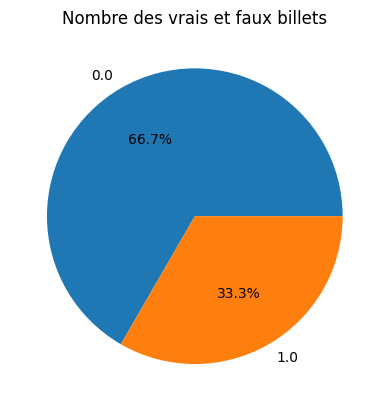

In [22]:
data=train_df['target'].value_counts()
labels=data.index
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title('Nombre des vrais et faux billets')
plt.show()

1=faux
0=vrai

## 2.3 Nettoyage des données

In [23]:
#Nombre des valeurs manquantes dans chaque colonne
train_df.isnull().sum()

diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
target           0
dtype: int64

In [24]:
#Nombre des valeurs manquantes dans chaque colonne
tmp = train_df.isnull().mean()
tmp[tmp > 0]

margin_low    0.024667
dtype: float64

On a 37 valeurs manquantes dans la colonne margin_low

In [25]:
# Pourçentage des valeurs manquantes 
print('Percent of missing "margin_low" records is %.2f%%' %((train_df['margin_low'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "margin_low" records is 2.47%


~2,5% des données dans la colonne margin_low est manquantes. -> voir la distribution de cette variable

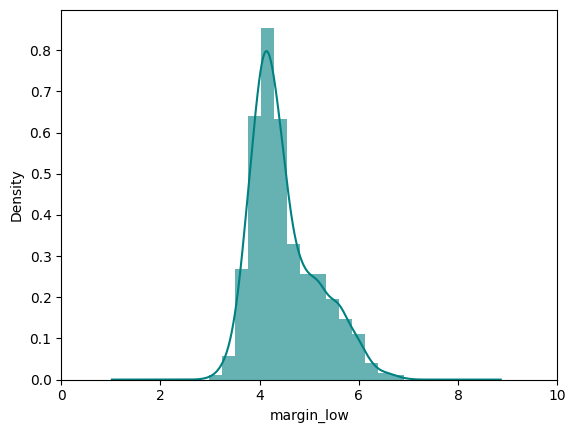

In [26]:
# la distribution de la variable 'margin_low'
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

### 2.3.1 Imputation des valeurs manquantes

In [27]:
train_df

,diagonal,height_left,height_right,margin_low,margin_up,length,target
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0
3,171.36,103.91,103.94,3.62,3.01,113.51,0.0
4,171.73,104.28,103.46,4.04,3.48,112.54,0.0
...,...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28,1.0
1496,172.19,104.63,104.44,5.27,3.37,110.97,1.0
1497,171.80,104.01,104.12,5.51,3.36,111.95,1.0
1498,172.06,104.28,104.06,5.17,3.46,112.25,1.0


On a un DataFrame qui contient X=6 (features)

## Imputation des valeurs manquantes

## les valeurs manquantes sont de type numerique

*** 1. La methode regression lineaire de sklearn ***

In [28]:
# Séparer les données en deux ensembles : avec et sans valeurs manquantes

test= train_df[train_df['margin_low'].isna()] #DataFrame qui contient que des valeurs manquantes dans la colonne margin_low

train = train_df[~train_df['margin_low'].isna()] #dataframe sans valeurs manquantes

In [29]:
test.shape

(37, 7)

In [30]:
train.shape

(1463, 7)

In [31]:
#les variables explicative (X)
X_train = train.drop(columns=['margin_low', 'target'])
X_train = train[['diagonal', 'height_left']] # Test with 2 cols
X_train.head()

,diagonal,height_left
0,171.81,104.86
1,171.46,103.36
2,172.69,104.48
3,171.36,103.91
4,171.73,104.28


In [32]:
# Création d'une instance de StandardScaler
scaler_1 = StandardScaler()
# Adapter le scaler aux données
scaler_1.fit(X_train)

# Standardiser les données
X_train_scaled = scaler_1.transform(X_train)
X_train_scaled[:5]

array([[-0.48859357,  2.76680735],
       [-1.63480853, -2.24148961],
       [ 2.39331832,  1.49803879],
       [-1.96229852, -0.40511406],
       [-0.75058556,  0.83026586]])

In [33]:
#la variable cible (y) (target)
y_train= train['margin_low']
y_train.shape

(1463,)

In [34]:
# Initialiser les modèles
models = {
    'Linear Regression': LinearRegression(),
    'Naive Model (median)': DummyRegressor(strategy='median'),
    'Naive Model (Mean)': DummyRegressor(strategy='mean')
}

# La validation croisée et les scores RMSE pour chaque modèle
results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = (-scores) ** 0.5
    results[model_name] = {'mean_rmse': rmse_scores.mean(), 'std_rmse': rmse_scores.std()}

# Affichage des résultats
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print(f"Standard deviation of RMSE: {result['std_rmse']}\n")


Model: Linear Regression
Mean RMSE: 0.6874318106352245
Standard deviation of RMSE: 0.17965714486343165

Model: Naive Model (median)
Mean RMSE: 0.6822920177155671
Standard deviation of RMSE: 0.31702538904937455

Model: Naive Model (Mean)
Mean RMSE: 0.7213898563877186
Standard deviation of RMSE: 0.20682302212606174



Selon les métriques de RMSE (erreur), le modèle de régression linéaire démontre la meilleure performance parmi les trois modèles testés.

In [35]:
## Model_1: Régression linéaire
# Créer et entraîner le modèle de régression linéaire
model_1 = LinearRegression()
model_1.fit(X_train_scaled, y_train)

LinearRegression()

In [36]:
#creation de la variable X_test
X_test = test.drop(columns=['margin_low', 'target'])
X_test = test[['diagonal', 'height_left']] # Test with 2 cols

In [37]:
X_test.head()

,diagonal,height_left
72,171.94,103.89
99,171.93,104.07
151,172.07,103.80
197,171.45,103.66
241,171.83,104.14


In [38]:
# Standardisation des données de X_test
X_test_scaled = scaler_1.transform(X_test)
X_test_scaled[:5]

array([[-0.06285659, -0.47189135],
       [-0.09560559,  0.12910429],
       [ 0.3628804 , -0.77238917],
       [-1.66755753, -1.23983022],
       [-0.42309557,  0.36282481]])

In [39]:
# Prédire les valeurs manquantes
y_predicted = model_1.predict(X_test_scaled)

In [40]:
y_predicted.shape

(37,)

In [41]:
y_predicted

array([4.39541206, 4.51950757, 4.30155414, 4.36479312, 4.59222542,
       4.00561199, 4.35998478, 4.29001186, 4.12283576, 4.148484  ,
       4.65151882, 4.18539323, 4.4316209 , 4.28923029, 4.25272128,
       4.45492444, 4.42653128, 4.26103724, 4.45931368, 4.31632274,
       4.35655835, 4.6456665 , 4.59114369, 4.66201711, 4.28668548,
       4.25869253, 4.25594761, 4.46079563, 4.60464932, 4.74617718,
       4.86371999, 4.59252559, 4.74205036, 4.53535791, 4.83630851,
       4.50930945, 4.66895117])

In [42]:
#Creation d'une copy de notre DataFrame
df_reg=train_df.copy()

In [43]:
# Remplacement des valeurs manquantes par les valeurs prédites
df_reg.loc[df_reg['margin_low'].isna(), 'margin_low'] = y_predicted

In [44]:
#Verification
df_reg.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
target          0
dtype: int64

In [45]:
# preview adjusted train data
df_reg.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,target
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0
3,171.36,103.91,103.94,3.62,3.01,113.51,0.0
4,171.73,104.28,103.46,4.04,3.48,112.54,0.0


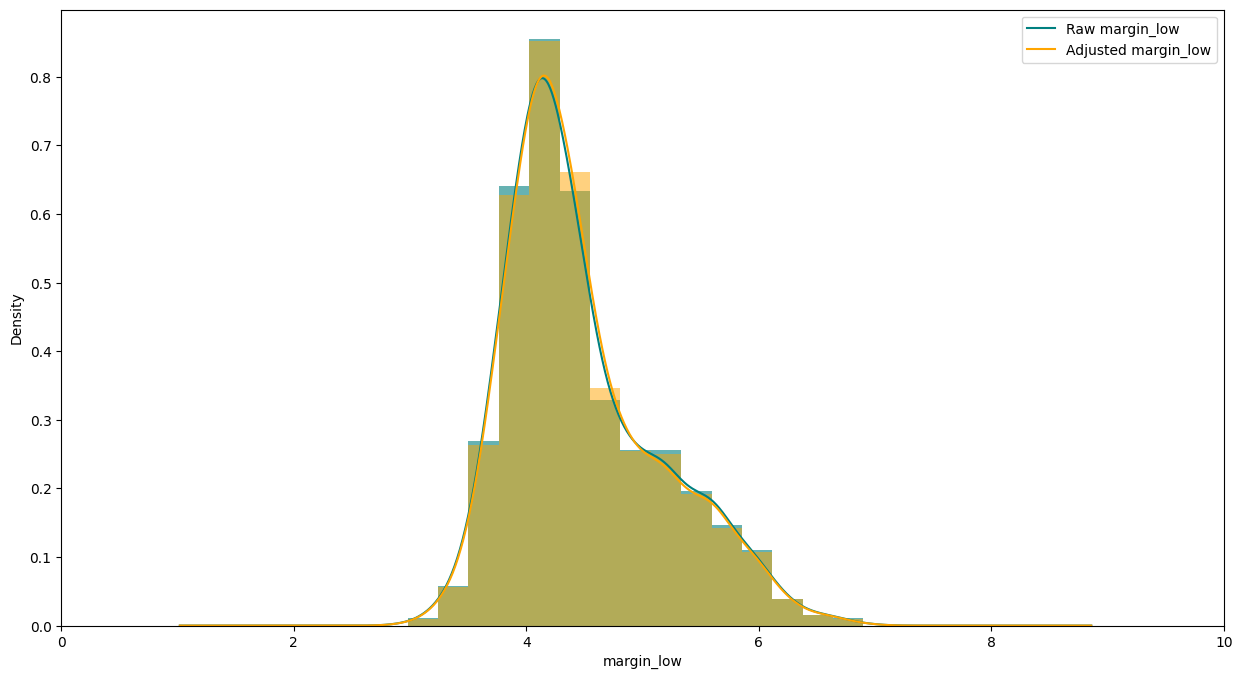

In [46]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_reg["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_reg["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

2. La méthode de régression linéaire de Statsmodels

In [47]:
# Créer et ajuster le modèle aux données d'entraînement
model_2 = sm.OLS(y_train, X_train_scaled)
model_fit = model_2.fit()

# Faire des prédictions sur les données de test mises à l'échelle
predicted_values = model_fit.predict(X_test_scaled)

# Afficher les valeurs prédites
print(predicted_values)

[-0.09055513  0.03354038 -0.18441305 -0.12117407  0.10625823 -0.4803552
 -0.12598241 -0.19595533 -0.36313143 -0.33748319  0.16555163 -0.30057396
 -0.05434629 -0.1967369  -0.23324591 -0.03104275 -0.05943592 -0.22492995
 -0.02665351 -0.16964445 -0.12940884  0.15969931  0.1051765   0.17604992
 -0.19928171 -0.22727466 -0.23001958 -0.02517156  0.11868213  0.26020999
  0.3777528   0.1065584   0.25608317  0.04939072  0.35034131  0.02334226
  0.18298398]


Avec Statsmodels, on doit ajouter manuellement une colonne qui contient une constante

In [48]:
#On a besoin d'une constante dans ce maodéle
X_train_scaled_with_const = sm.add_constant(X_train_scaled)
X_test_scaled_with_const = sm.add_constant(X_test_scaled)
X_test_scaled_with_const[:5]

array([[ 1.        , -0.06285659, -0.47189135],
       [ 1.        , -0.09560559,  0.12910429],
       [ 1.        ,  0.3628804 , -0.77238917],
       [ 1.        , -1.66755753, -1.23983022],
       [ 1.        , -0.42309557,  0.36282481]])

In [49]:
model_2 = sm.OLS(y_train, X_train_scaled_with_const).fit()

In [50]:
model_2.params

const    4.485967
x1      -0.077707
x2       0.202249
dtype: float64

In [51]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     85.92
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           5.30e-36
Time:                        15:08:27   Log-Likelihood:                -1394.5
No. Observations:                1463   AIC:                             2795.
Df Residuals:                    1460   BIC:                             2811.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4860      0.016    273.084      0.000       4.454       4.518
x1            -0.0777      0.016     -4.730      0.000      -0.110      -0.045
x2             0.2022      0.016     12.310      0.000       0.170       0.234
==============================================================================
Omnibus:                      102.091   Durbin-Watson:                   1.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.302
Skew:                           0.687   Prob(JB):                     2.77e-27
Kurtosis:                       3.344   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
model_2.pvalues

const    0.000000e+00
x1       2.466888e-06
x2       3.334812e-33
dtype: float64

In [53]:
#Pour déterminer quelles variables éliminer, nous devons examiner leurs valeurs p.
significant_variables = model_2.pvalues[model_2.pvalues < 0.05].index
significant_variables

Index(['const', 'x1', 'x2'], dtype='object')

Toutes les variables sont considérées comme significatives au seuil de valeur p actuel (0,05), donc on doit les conserver toutes.

In [54]:
y_train.mean()

4.485967190704033

In [55]:
predicted_values = model_2.predict(X_test_scaled_with_const)

In [56]:
predicted_values

array([4.39541206, 4.51950757, 4.30155414, 4.36479312, 4.59222542,
       4.00561199, 4.35998478, 4.29001186, 4.12283576, 4.148484  ,
       4.65151882, 4.18539323, 4.4316209 , 4.28923029, 4.25272128,
       4.45492444, 4.42653128, 4.26103724, 4.45931368, 4.31632274,
       4.35655835, 4.6456665 , 4.59114369, 4.66201711, 4.28668548,
       4.25869253, 4.25594761, 4.46079563, 4.60464932, 4.74617718,
       4.86371999, 4.59252559, 4.74205036, 4.53535791, 4.83630851,
       4.50930945, 4.66895117])

In [57]:
df_stat=train_df.copy()

In [58]:
df_stat.loc[df_stat['margin_low'].isnull(), 'margin_low'] = predicted_values

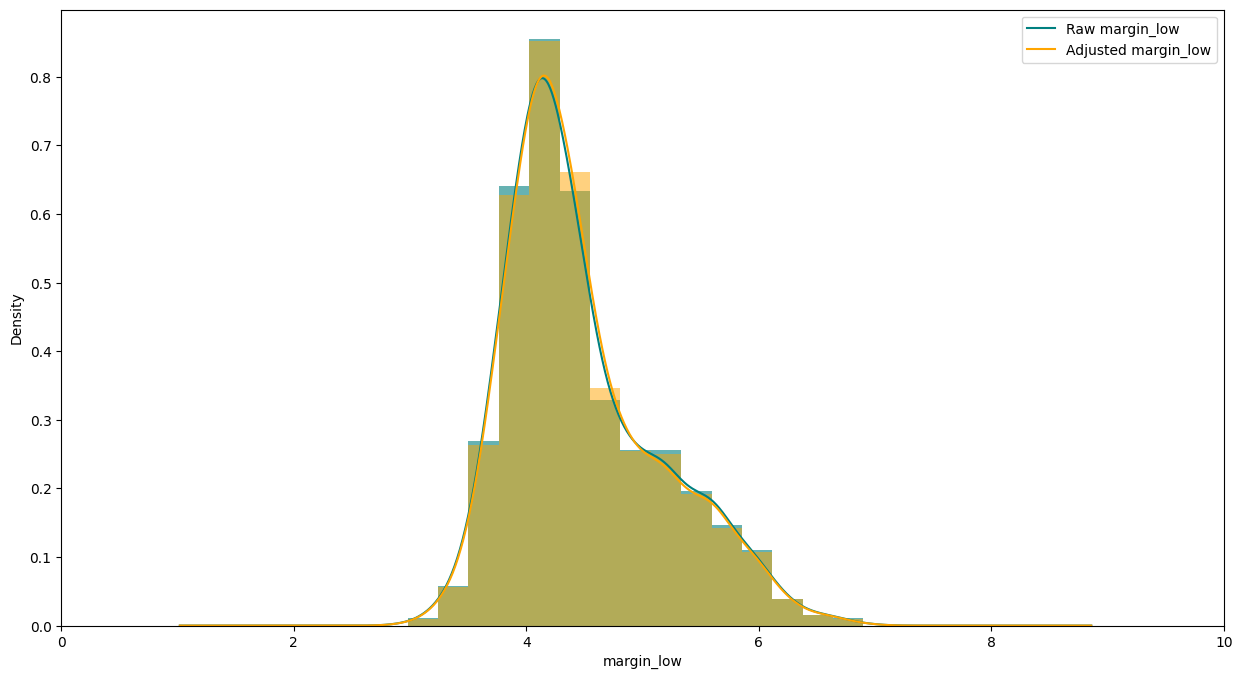

In [59]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_stat["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_stat["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

### Tests statistiques

Pour confirmer que la distribution, la moyenne et la variance de la colonne 'margin_low' restent les mêmes après l'imputation des valeurs nulles

Distribution test : On peut utiliser un test statistique non paramétrique comme le test de Kolmogorov-Smirnov pour comparer la distribution de la colonne originale avec celle de la colonne remplie.

Test de moyenne : On peut effectuer un test t pour comparer les moyennes de la colonne originale et de la colonne remplie. Assurez-vous que vos données répondent aux hypothèses du test t (distribution normale ou échantillon suffisamment grand).

Test de variance : On peut utiliser un test de F pour comparer les variances de la colonne originale et de la colonne remplie. Encore une fois, assurez-vous que vos données répondent aux hypothèses du test de F (distribution normale ou échantillon suffisamment grand).

In [60]:
df_reg["margin_low"].shape, y_train.shape

((1500,), (1463,))

In [61]:
# Test de distribution
def test_distribution(original, filled):
    _, p_value = stats.ks_2samp(original, filled)
    if p_value < 0.05:
        print(p_value, " -> La distribution n'est pas la même.")
    else:
        print(p_value, " -> La distribution est similaire.")

# Test de moyenne
def test_moyenne(original, filled):
    _, p_value = stats.ttest_ind(original, filled)
    if p_value < 0.05:
        print(p_value, " -> Les moyennes ne sont pas les mêmes.")
    else:
        print(p_value, " -> Les moyennes sont similaires.")

# Test de variance
def test_variance(original, filled):
    _, p_value = stats.levene(original, filled)
    if p_value < 0.05:
        print(p_value, " -> Les variances ne sont pas les mêmes.")
    else:
        print(p_value, " -> Les variances sont similaires.")

# Exécution des tests
test_distribution(y_train, df_reg["margin_low"])
test_moyenne(y_train, df_reg["margin_low"])
test_variance(y_train, df_reg["margin_low"])


0.999999987793279  -> La distribution est similaire.
0.9663436894636668  -> Les moyennes sont similaires.
0.6381585910082304  -> Les variances sont similaires.


### Residuals

In [62]:
X_train_scaled.shape, y_train.shape

((1463, 2), (1463,))

In [63]:
# y_pred = model_1.predict(X_train_scaled)
# residuals = y_train - y_pred
residuals = model_2.resid
residuals

0      -0.563518
1      -0.389664
2      -0.202967
3      -0.936517
4      -0.672213
          ...   
1495   -0.354652
1496    0.438500
1497    0.997927
1498    0.541766
1499   -0.060592
Length: 1463, dtype: float64

<Axes: xlabel='margin_low', ylabel='None'>

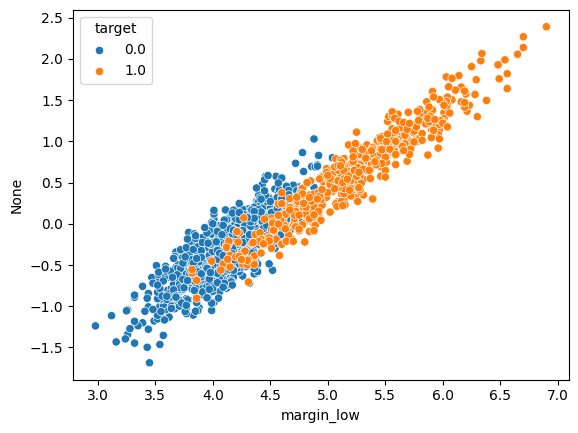

In [64]:
sns.scatterplot(x=train_df.margin_low, y=residuals, hue=train_df.target)

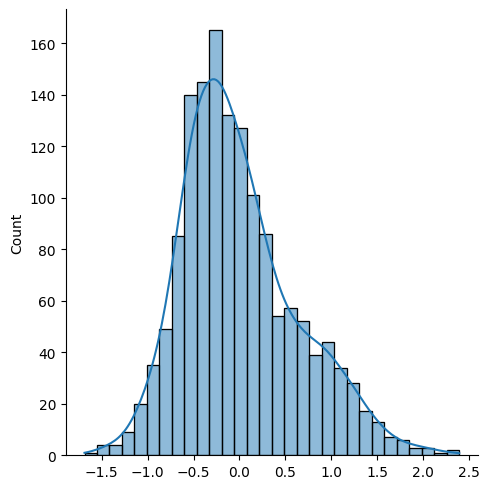

In [65]:
sns.displot(data=residuals, kde=True)
plt.show()


Le test de Shapiro-Wilk est un test statistique utilisé pour déterminer si un échantillon de données suit une distribution normale (gaussienne). Il est basé sur la comparaison entre les moments observés des données et ceux attendus sous l'hypothèse de normalité.

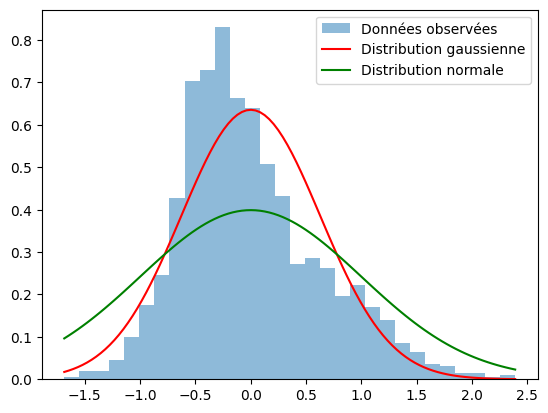

Test de Kolmogorov-Smirnov:
Statistique de test: 0.07721845746363476
P-value: 4.9277927903156814e-08
4.9277927903156814e-08  -> Les résidus ne suivent pas une distribution normale

Test de Shapiro-Wilk:
Statistique de test: 0.9672539640993832
P-value: 1.0873907103115417e-17
1.0873907103115417e-17  -> Les résidus ne suivent pas une distribution normale


In [66]:
# Calculer la moyenne et la variance
mean = 0
variance = np.var(residuals)

# Créer une distribution normale
normal_dist = stats.norm(loc=0, scale=1)
# Créer une distribution gaussienne
gaussian_dist = stats.norm(loc=mean, scale=np.sqrt(variance))

# Visualiser les données et la distribution gaussienne
plt.hist(residuals, bins=30, density=True, alpha=0.5, label='Données observées')
x = np.linspace(np.min(residuals), np.max(residuals), 100)
plt.plot(x, gaussian_dist.pdf(x), 'r', label='Distribution gaussienne')
plt.plot(x, normal_dist.pdf(x), 'g', label='Distribution normale')
plt.legend()
plt.show()

# Tester l'ajustement
kstest_result = stats.kstest(residuals, 'norm', args=(mean, np.sqrt(variance)))
shapiro_result = stats.shapiro(residuals)

print("Test de Kolmogorov-Smirnov:")
print("Statistique de test:", kstest_result.statistic)
p_value = kstest_result.pvalue
print("P-value:", p_value)
if p_value < 0.05:
    print(p_value, " -> Les résidus ne suivent pas une distribution normale")
else:
    print(p_value, " -> Les résidus suivent une distribution normale")
print("\nTest de Shapiro-Wilk:")
print("Statistique de test:", shapiro_result.statistic)
p_value = shapiro_result.pvalue
print("P-value:", p_value)
if p_value < 0.05:
    print(p_value, " -> Les résidus ne suivent pas une distribution normale")
else:
    print(p_value, " -> Les résidus suivent une distribution normale")


Pour évaluer l'homoscédasticité des résidus, nous utilisons le test statistique de Breusch-Pagan. Ce test compare la variance des résidus avec une ou plusieurs variables indépendantes pour déterminer s'ils présentent une homoscédasticité. En d'autres termes, il examine l'uniformité de la dispersion des résidus sur toute la plage des valeurs prises par les variables indépendantes. <br>L'hétéroscédasticité, qui est le contraire de l'homoscédasticité, se manifeste lorsque la variance des résidus varie de manière non constante à travers les valeurs prédites de la variable dépendante.

In [67]:
# Test de Breusch-Pagan
test_bp = het_breuschpagan(residuals, X_train_scaled_with_const)
print("Test de Breusch-Pagan:")
print("Statistique de test:", test_bp[0])
p_value = test_bp[1]
print("P-value:", p_value)
if p_value < 0.05:
    print(p_value, " -> Les résidus présentent une hétéroscédasticité")
else:
    print(p_value, " -> Les résidus présentent une homoscédasticité")

Test de Breusch-Pagan:
Statistique de test: 68.78141381493074
P-value: 1.1595934707513714e-15
1.1595934707513714e-15  -> Les résidus présentent une hétéroscédasticité


La multicollinéarité: C'est une condition dans laquelle deux ou plus de deux variables indépendantes (ou prédictives) dans un modèle de régression sont fortement corrélées entre elles. En d'autres termes, il existe une relation linéaire élevée entre au moins deux des variables indépendantes.<br>plusieurs méthodes pour vérifier la multicollinéarité dans un modèle de régression,parmi les quelles:<br>
Variance Inflation Factor (VIF) : Le VIF mesure l'importance de la multicollinéarité dans une régression. Un VIF élevé (généralement supérieur à 10) indique une multicollinéarité problématique.<br>Les variable avec un vif relativement faible contribue de manière unique à expliquer la variation dans la variable dépendante, ce qui est souhaitable dans de nombreux modèles statistiques.

In [68]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train.shape[1])]
print(vif_data, '\n')

seuil = 10 # Un seuil de 10 est couramment utilisé
for index, row in vif_data.iterrows():
    feature = row['feature']
    vif = row['VIF']
    if vif > seuil:
        print(f"La variable '{feature}' a un VIF élevé de {vif:.2f}, ce qui indique une forte corrélation avec d'autres variables explicatives.")
    else:
        print(f"La variable '{feature}' a un VIF de {vif:.2f}, ce qui indique qu'elle est indépendante des autres variables explicatives.")

       feature       VIF
0     diagonal  1.000334
1  height_left  1.000334 

La variable 'diagonal' a un VIF de 1.00, ce qui indique qu'elle est indépendante des autres variables explicatives.
La variable 'height_left' a un VIF de 1.00, ce qui indique qu'elle est indépendante des autres variables explicatives.


Les valeurs de VIF pour toutes les variables sont inférieures à 10, ce qui suggère qu'il n'y a pas de forte multicollinéarité entre les variables explicatives.<br> Cependant, il est toujours possible que des problèmes de multicollinéarité moins graves puissent influencer les estimations de coefficient dans le modèle.

In [69]:
correlation_matrix = pd.DataFrame(X_train_scaled, columns=X_train.columns).corr()
correlation_matrix

,diagonal,height_left
diagonal,1.000000,0.018265
height_left,0.018265,1.000000


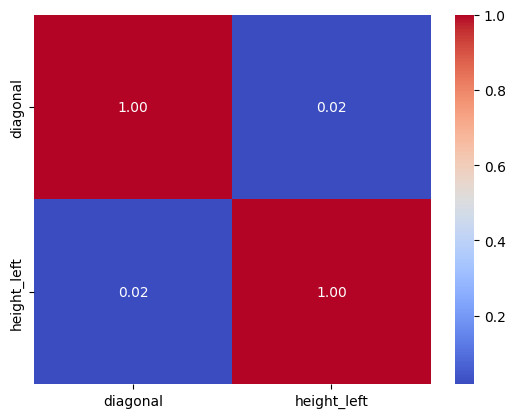

In [70]:
# Matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [71]:
# Calcul des valeurs propres
eigenvalues, _ = np.linalg.eig(correlation_matrix)
eigenvalues

array([1.01826548, 0.98173452])

Il semble que la première variable 'diagonal' contient le plus d'information car elle a la plus grande valeur propre. On doit maintenant choisir une deuxième variable qui est la moins corrélée avec la première.
<br>
En regardant la matrice de corrélation, on voit que la corrélation entre 'diagonal' et 'height_left' est très faible. On peut donc choisir ces deux variables car elles fournissent une information significative et elles ne sont pas fortement corrélées entre elles.

***Exploration des données***

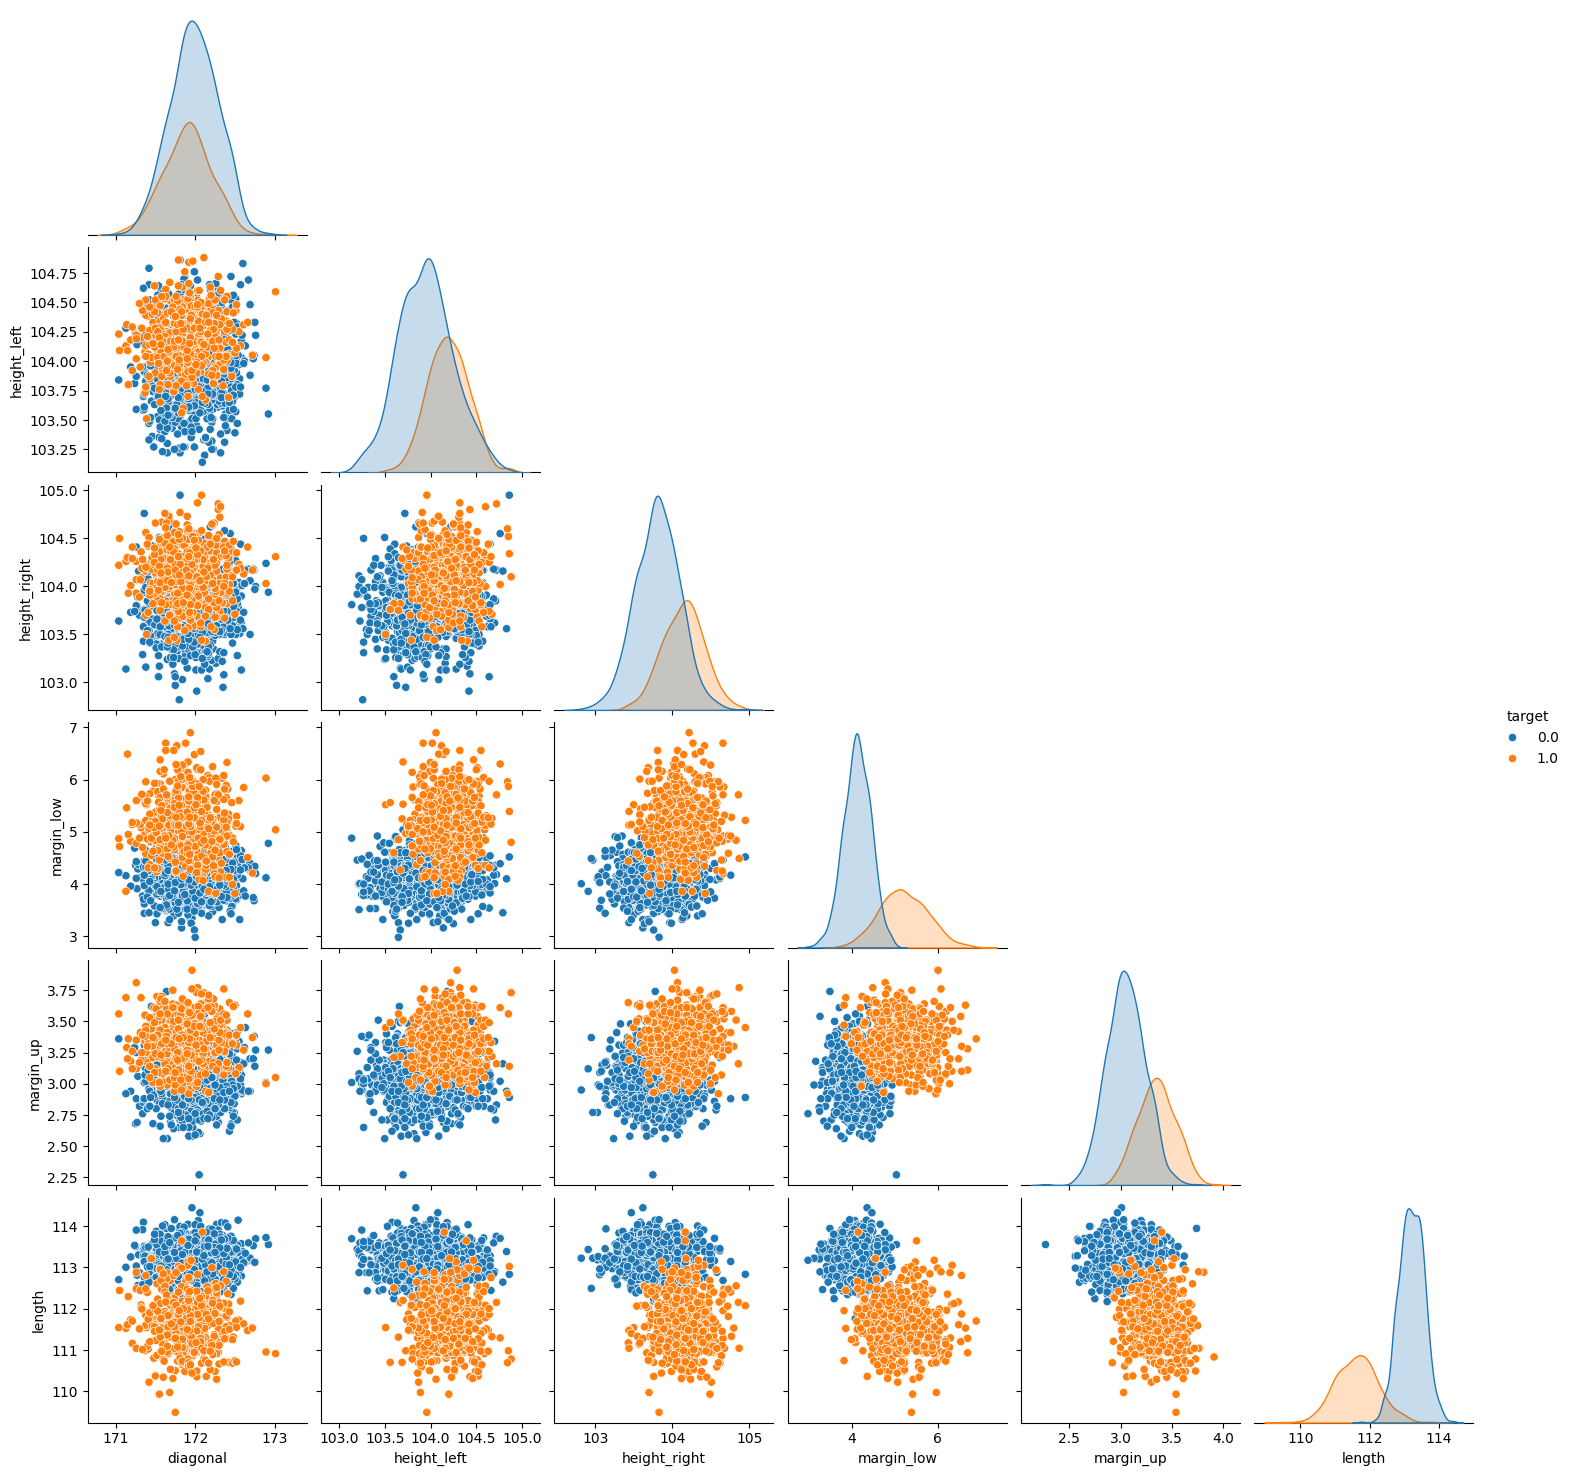

In [72]:
sns.pairplot(df_reg, hue='target', corner=True)
plt.show()

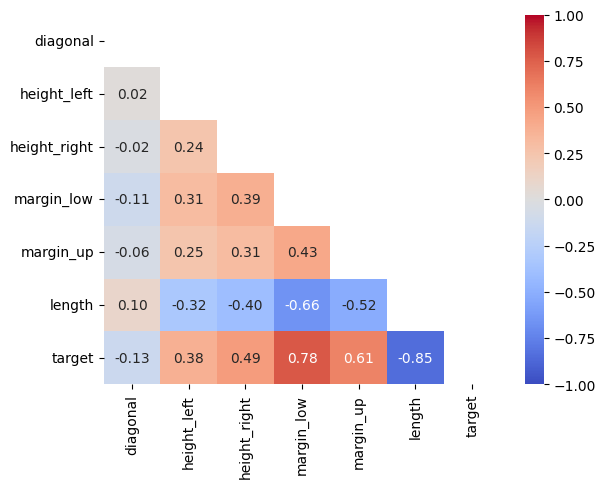

In [73]:
correlation_matrix = df_reg.corr()
masque=np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=masque, vmin=-1, vmax=1)
plt.show()

la target est tres correlée avec la longeur des billets

## 2.3.2 Detection des outliers

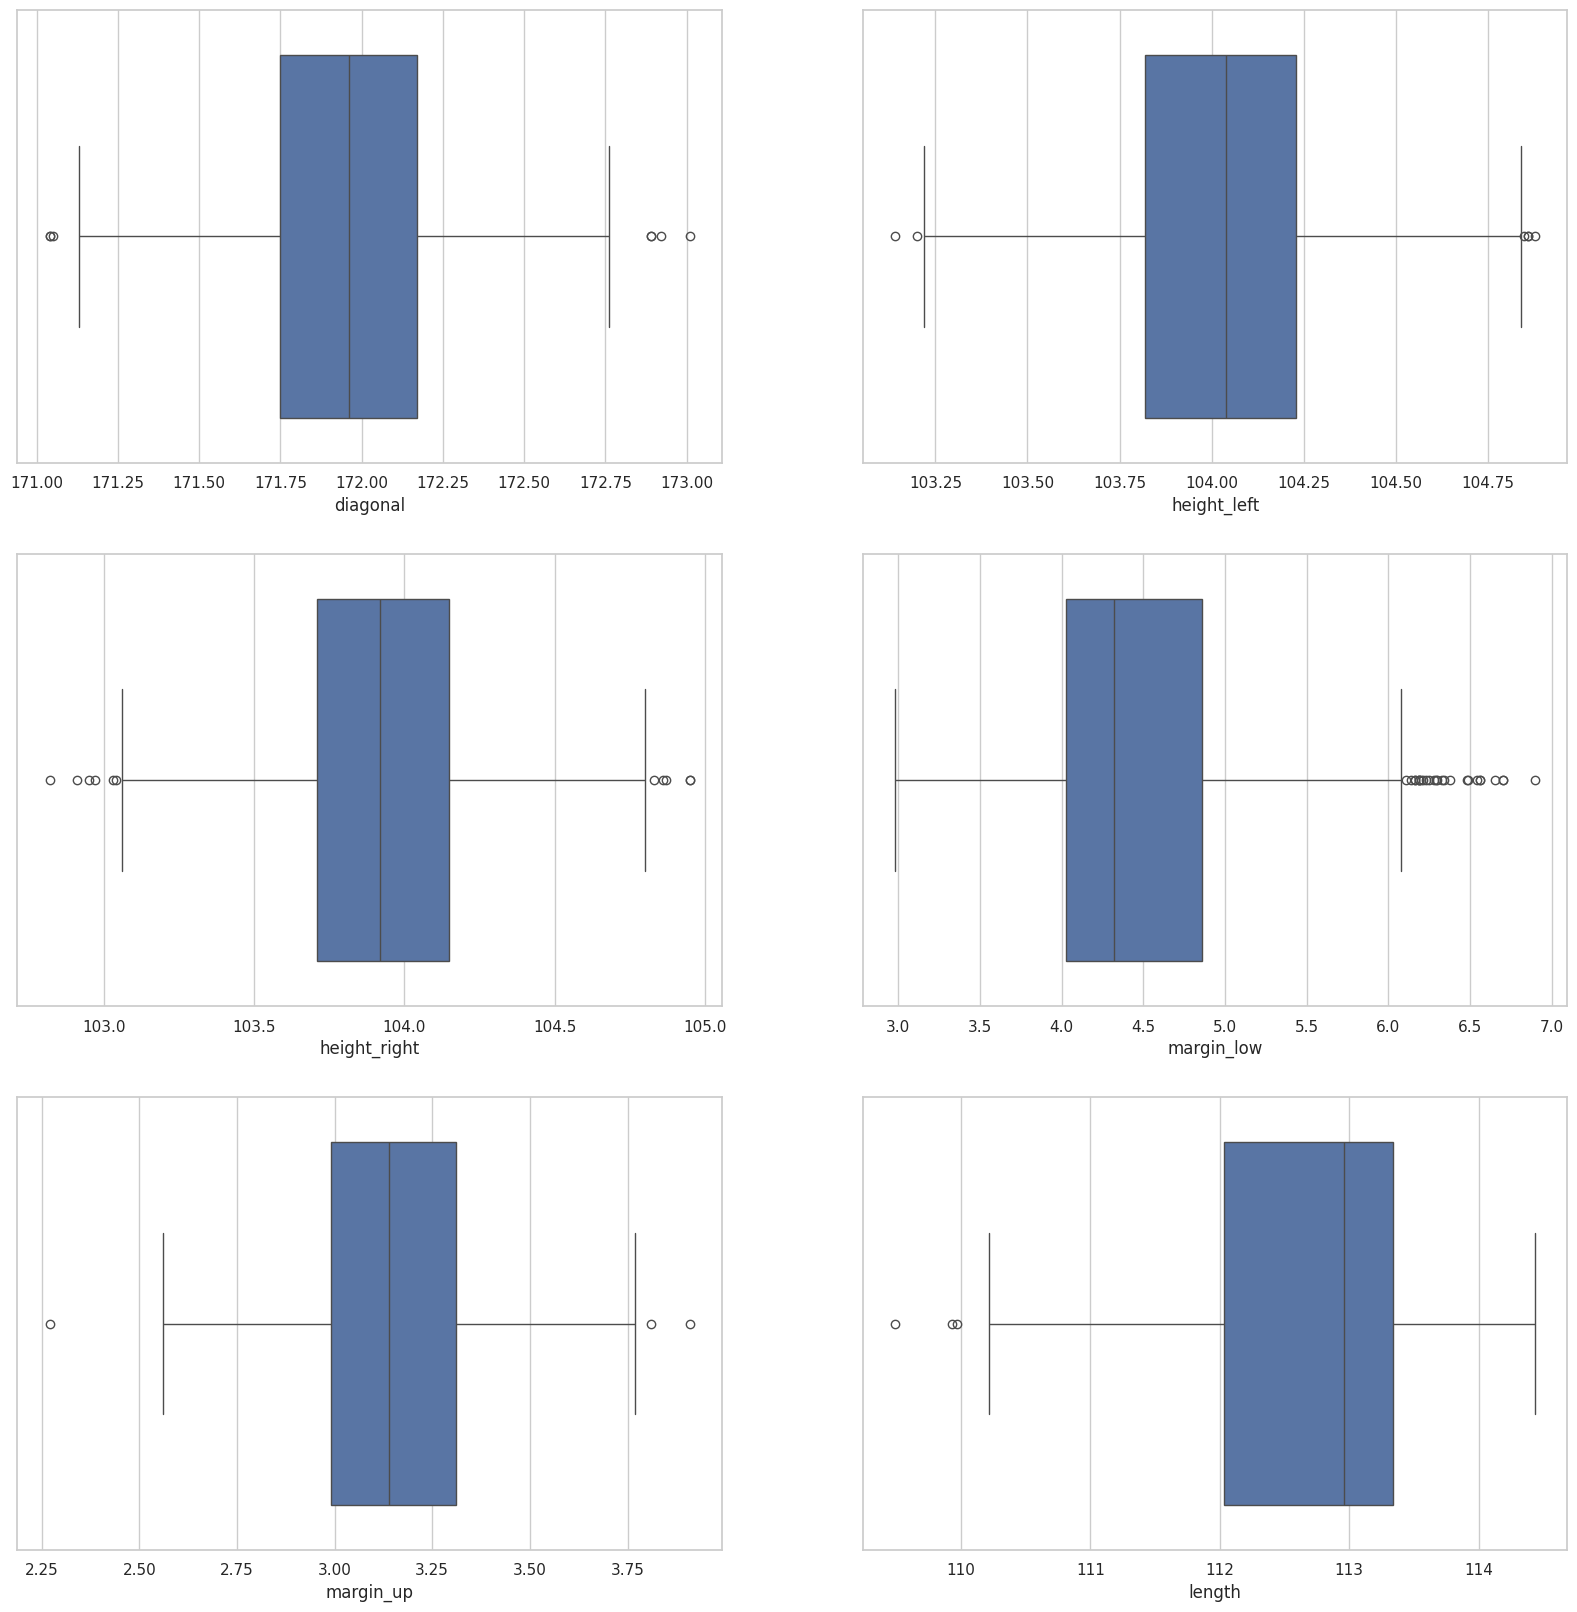

In [74]:
plt.figure(figsize=(20, 20))
sns.set_theme(style="whitegrid")

plt.subplot(321)
sns.boxplot(data=df_reg, x='diagonal')

plt.subplot(322)
sns.boxplot(data=df_reg, x='height_left')

plt.subplot(323)
sns.boxplot(data=df_reg, x='height_right')

plt.subplot(324)
sns.boxplot(data=df_reg, x='margin_low')

plt.subplot(325)
sns.boxplot(data=df_reg, x='margin_up')

plt.subplot(326)
sns.boxplot(data=df_reg, x='length')

plt.show()

Les boxplots révèlent la présence d'outliers dans plusieurs features. <br> Cela suggère que ces valeurs pourraient être liées à des faux billets, caractérisés par des dimensions non conformes, ou bien à des billets de grande valeur, comme les billets de 500€, ou de petites valeurs comme celles de 5€. <br> Ainsi, il est prévu de conserver les outliers afin de poursuivre l'analyse.

## Test with 2 cols

## 2.3.1.1 Data mining

## 2.4 Preparation des données

## Choix du modéle

Type de données categorielles


2.5 Modelisation avec split

2.5.1 Dummy clussifier

In [75]:
X=df_reg.drop(columns='target')
X = df_reg[['length', 'margin_low']] # Test with 2 cols
y=df_reg['target']

In [76]:
train_X, test_X, train_y, test_y = train_test_split (X, y, test_size=0.3, random_state=42)

In [77]:
estimator_1= DummyClassifier(strategy="most_frequent")
estimator_1.fit(train_X, train_y)

DummyClassifier(strategy='most_frequent')

In [78]:
y_pred_1 = estimator_1.predict(test_X)
y_pred_1[:5]

array([0., 0., 0., 0., 0.])

In [79]:
pd.Series(y_pred_1).value_counts()

0.0    450
Name: count, dtype: int64

In [80]:
test_y.value_counts(normalize=True)

target
0.0    0.642222
1.0    0.357778
Name: proportion, dtype: float64

In [81]:
test_y.value_counts()

target
0.0    289
1.0    161
Name: count, dtype: int64

In [82]:
train_X.head()

,length,margin_low
485,113.21,4.000000
527,113.00,3.840000
199,112.87,4.380000
889,113.80,4.000000
844,113.35,4.645666


In [83]:
tr_score= estimator_1.score(train_X, train_y)
te_score= estimator_1.score(test_X, test_y)
print(f"le score de train est {tr_score}, et de test est {te_score}")

le score de train est 0.6771428571428572, et de test est 0.6422222222222222


In [84]:
y_pred_1 = estimator_1.predict(test_X)
y_pred_1[:5]

array([0., 0., 0., 0., 0.])

In [85]:
test_y.values

array([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0.

In [86]:
1 - abs(y_pred_1 - test_y.values).mean()

0.6422222222222222

In [87]:
mat=confusion_matrix(test_y, y_pred_1, labels=estimator_1.classes_)
mat

array([[289,   0],
       [161,   0]])

In [88]:
test_y.value_counts()

target
0.0    289
1.0    161
Name: count, dtype: int64

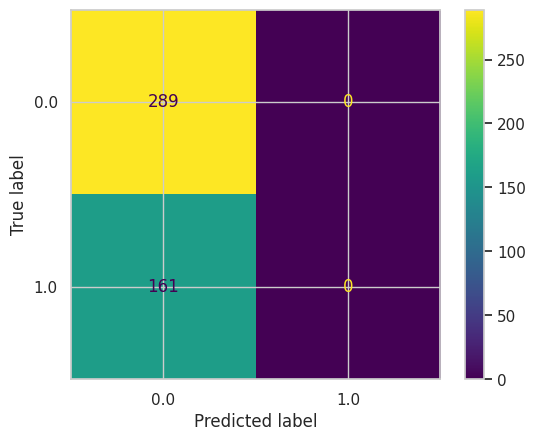

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels= estimator_1.classes_)
disp.plot()
plt.show()

## 2. Regression logistique

In [90]:
estimator_2 = LogisticRegression(solver='liblinear') #small dataset

In [91]:
estimator_2.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [92]:
y_pred_2=estimator_2.predict(test_X)
y_pred_2[:5]

array([1., 1., 0., 0., 0.])

In [93]:
y_prob = estimator_2.predict_proba(test_X).round(2) #La probabilité de l'appartenance à tel ou tel classe
y_prob[:5]

array([[0.13, 0.87],
       [0.  , 1.  ],
       [0.97, 0.03],
       [0.96, 0.04],
       [0.97, 0.03]])

In [94]:

conf=confusion_matrix(test_y, y_pred_2, labels=estimator_2.classes_)
conf

array([[284,   5],
       [ 21, 140]])

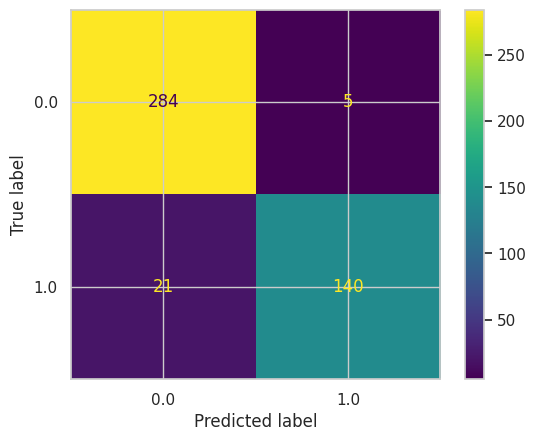

In [95]:

disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels= estimator_2.classes_)
disp.plot()
plt.show()

## SVM

In [96]:
estimator_3 = LinearSVC()

In [97]:
estimator_3.fit(train_X, train_y)

/tmp/Project_10_Detection_des_faux_billets_avec_Python/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/tmp/Project_10_Detection_des_faux_billets_avec_Python/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [98]:
y_pred_3=estimator_3.predict(test_X)
y_pred_3[:5]

array([1., 1., 0., 0., 0.])

In [99]:
conf=confusion_matrix(test_y, y_pred_3, labels=estimator_3.classes_)
conf

array([[282,   7],
       [ 20, 141]])

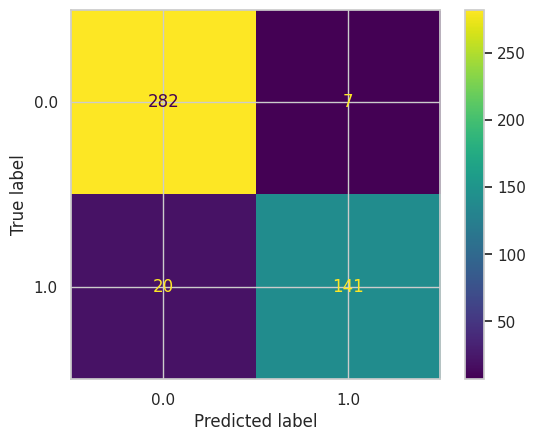

In [100]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels= estimator_3.classes_)
disp.plot()
plt.show()

Modelisation avec cross_validation

In [101]:
X=df_reg.drop(columns=['target'])
X = df_reg[['length', 'margin_low']] # Test with 2 cols
y=df_reg['target']

In [102]:
# Création d'une instance de StandardScaler
scaler_2 = StandardScaler()
# Adapter le scaler aux données
scaler_2.fit(X)

# Standardiser les données
X_scaled = scaler_2.transform(X)
X_scaled[:5]

array([[ 0.17365114,  0.05342666],
       [ 0.47166629, -1.08959252],
       [ 0.55190114, -0.12945641],
       [ 0.95307539, -1.31819636],
       [-0.15875038, -0.67810562]])

In [103]:
#Choix du modele
Logistic_Regression = LogisticRegression()
svc = SVC()
Majority_Model = DummyClassifier(strategy='most_frequent')

# Initialiser les modèles
models = {
    'Logistic Regression': Logistic_Regression,
    'SVC': svc,
    'Majority Model': Majority_Model
}

# La validation croisée et les scores de précision pour chaque modèle
results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    results[model_name] = {'mean_accuracy': scores.mean(), 'std_accuracy': scores.std()}

# Affichage des résultats
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {result['mean_accuracy']}")
    print(f"Standard deviation of Accuracy: {result['std_accuracy']}\n")


Model: Logistic Regression
Mean Accuracy: 0.986
Standard deviation of Accuracy: 0.00388730126323021

Model: SVC
Mean Accuracy: 0.9873333333333332
Standard deviation of Accuracy: 0.0048989794855663574

Model: Majority Model
Mean Accuracy: 0.6666666666666666
Standard deviation of Accuracy: 0.0



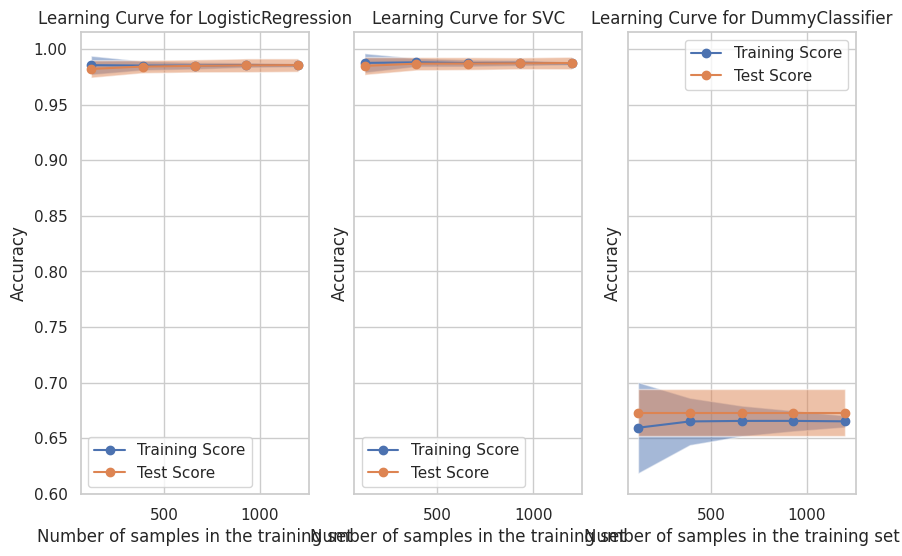

In [104]:
# Évaluation de la performance du modèle

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_scaled,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([Logistic_Regression, svc, Majority_Model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

En observant les courbes d'apprentissage, on peut déterminer que le modèle DummyClassifier montre un sous-apprentissage (underfitting) tandis que les deux modèles Logistic Regression et SVC sont comparables et montrent de bons résultats. <br> On a choisi d'optimiser le modele de Logistic Regression.

In [105]:
#Optimisation des hyperparamètres

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialiser LogisticRegression
logistic_regression = LogisticRegression()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy', n_jobs=4, verbose=1, return_train_score=True)

# Exécuter la recherche sur grille sur les données d'entraînement
grid_search.fit(X_scaled, y)

# Afficher les meilleurs hyperparamètres et le score associé
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9866666666666667


In [106]:
def resultize(grid_search) : 
    """build a DataFrame from the results of a GridSearchCV"""

    res = pd.DataFrame(grid_search.cv_results_)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.round(2).iloc[:, 4:].sort_values('mean_test_score', ascending=False)

    return res

In [107]:
resultize(grid_search).head(10)

,param_C,param_penalty,param_solver,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
12,1,l1,liblinear,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.99,0.0,1,0.99,0.0
13,1,l1,saga,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.99,0.0,1,0.99,0.0
22,100,l2,liblinear,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",0.99,0.0,1,0.99,0.0
21,100,l1,saga,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.99,0.0,1,0.99,0.0
20,100,l1,liblinear,"{'C': 100, 'penalty': 'l1', 'solver': 'libline...",0.99,0.0,1,0.99,0.0
19,10,l2,saga,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.99,0.0,1,0.99,0.0
18,10,l2,liblinear,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.99,0.0,1,0.99,0.0
17,10,l1,saga,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.99,0.0,1,0.99,0.0
16,10,l1,liblinear,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.99,0.0,1,0.99,0.0
15,1,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.99,0.0,12,0.99,0.0


In [108]:
#Choisir le bon modele
best_model = grid_search.best_estimator_

In [109]:
#matrice du confusion
y_pred = best_model.predict(X_scaled)
mat=confusion_matrix(y, y_pred)
mat

array([[993,   7],
       [ 13, 487]])

In [110]:
pd.DataFrame({"y_true" : y, "y_pred" : y_pred})

,y_true,y_pred
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1495,1.0,1.0
1496,1.0,1.0
1497,1.0,1.0
1498,1.0,1.0


<Axes: >

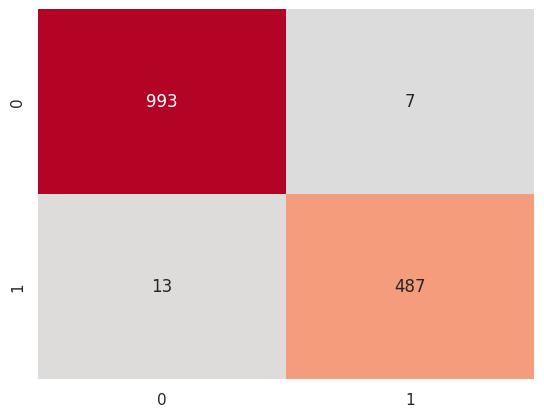

In [111]:
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt='d', cbar=False, vmax=1000, vmin=-1000)

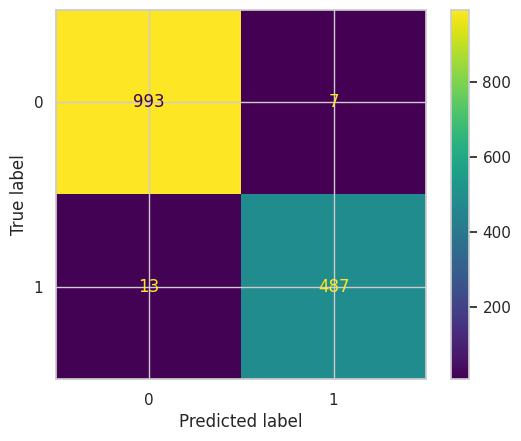

In [112]:
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()

On voit que nous avons 10 faux négatifs (10 faux billets classés comme vrais) et 4 faux positifs (4 vrais billets classés comme faux). <br> Nous allons changer la métrique de scoring afin d'avoir moins de faux négatifs.

### Choix metric

accuracy
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9866666666666667
[[993   7]
 [ 13 487]]


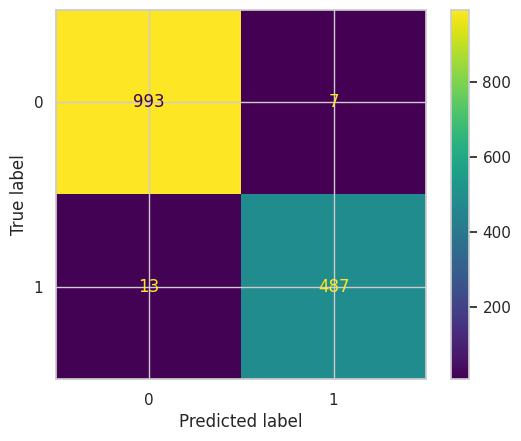

recall
Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.976
[[993   7]
 [ 12 488]]


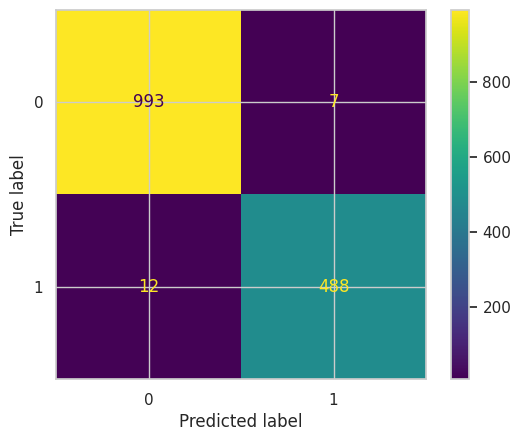

f1
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9798685876237816
[[993   7]
 [ 13 487]]


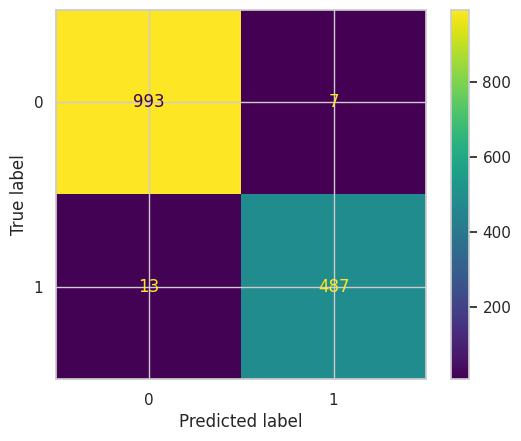

In [113]:
for sco in ['accuracy', 'recall', 'f1']: # , 'roc_auc', 'average_precision'
    print(sco)
    # Définir la grille des hyperparamètres à rechercher
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

    # Initialiser LogisticRegression
    logistic_regression = LogisticRegression()

    # Créer l'objet GridSearchCV
    grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring=sco)

    # Exécuter la recherche sur grille sur les données d'entraînement
    grid_search.fit(X_scaled, y)

    # Afficher les meilleurs hyperparamètres et le score associé
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    best_model = grid_search.best_estimator_

    #matrice de confusion
    y_pred = best_model.predict(X_scaled)
    mat=confusion_matrix(y, y_pred)
    print(mat)

    disp = ConfusionMatrixDisplay(confusion_matrix=mat)
    disp.plot()
    plt.show()


on choisit la metric f1 qui a le meilleur compromis et le moins de faux négatifs

### Choix du seuil de décision

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9798685876237816
[[993   7]
 [ 13 487]]


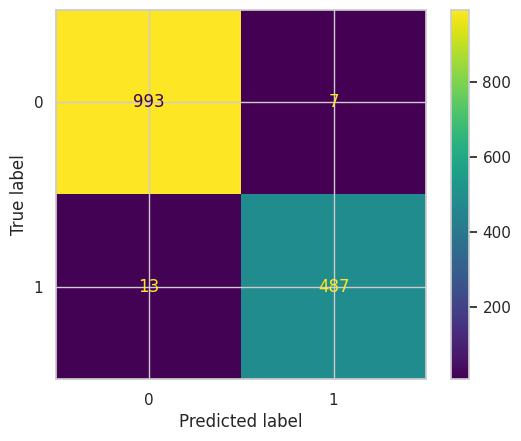

In [114]:
# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialiser LogisticRegression
logistic_regression = LogisticRegression()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='f1')

# Exécuter la recherche sur grille sur les données d'entraînement
grid_search.fit(X_scaled, y)

# Afficher les meilleurs hyperparamètres et le score associé
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

#matrice de confusion
y_pred = best_model.predict(X_scaled)
mat=confusion_matrix(y, y_pred)
print(mat)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()


[[982  18]
 [ 11 489]]


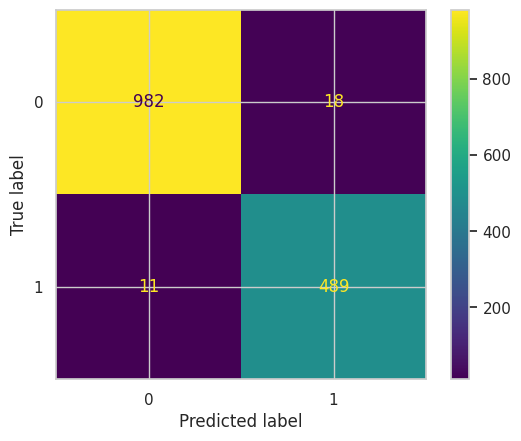

In [115]:
y_proba = best_model.predict_proba(X_scaled)
nouveau_seuil = 0.26
y_pred = (y_proba[:, 1] > nouveau_seuil).astype(int) #Faux billet si la probabilité est supérieure au seuil
mat=confusion_matrix(y, y_pred)
print(mat)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()

0.26 est le seuil qui a le meilleur compromis